# SIR model with time-varying $\beta$
We want to explore the effect of interventions in an epidemic. We model the effect of interventions as reducing the infection coefficient $\beta$.

The equations are
$$\begin{align}
\frac{\partial S_t}{\partial t} & = -\beta S_t \frac{I_t}{N} \\
\frac{\partial I_t}{\partial t} & = +\beta S_t \frac{I_t}{N} - \mu I_t \\
\frac{\partial R_t}{\partial t} & = +\mu I_t
\end{align}$$

where
$$\begin{align}
\beta &= \text{rate of infection} \\
\mu &= \text{rate of recovery}
\end{align}$$

Now 
$$R_0 = \frac{\beta}{\mu}$$

is the basic reproduction number. A basic result is that the number of people unaffected by the disease $S_\infty$ can be determined from the relation

$$S_\infty =e^{-R_0 (1-S_\infty)}$$

A guess for the value of $R_0$ for COVID-19 is 2.5. We will model the effect of measures like physical distancing as reducing $\beta$ and hence $R_0$ over time. We will therefore regard them as time-dependent quantities, $R_t$ and $\beta_t$.

Although in some ways it is only the ratio $\beta / \mu$ that matters, the magnitudes of $\beta$ and $\mu$ affect how quickly the epidemic unfolds.

To incorporate these ideas into the numerical integration, we will specify two times (step numbers), $t_1$ and $t_2$, in addition to the total number of steps $t_f - 1$. Then $\beta_t$ has the value $\beta_i$ for $t\le t_1$, $\beta_f$ for $t >= t_2$ and ramps linearly in between.

In [1]:
%matplotlib inline

from datetime import date

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from scipy.integrate import solve_ivp
from scipy.optimize import least_squares

plt.style.use('seaborn')

In [2]:
def calc_new_cases(cases_cum):
    """Calculate new cases based on cumulative cases. New cases are the total cases in the previous week."""
    # Do some funny business to impute weekly sums at beginning of time series
    cases_ext = backcast(np.log(cases_cum[:7] + 1e-7), 7)
    cases_ext = np.exp(cases_ext)

    cases_new = np.zeros_like(cases_cum)
    cases_new[:7] = cases_cum[:7] - cases_ext
    cases_new[7:] = cases_cum[7:] - cases_cum[:-7]
    
    return cases_new

In [3]:
def backcast(y, n):
    """Use linear regression to extrapolate values to before start of time series"""
    X = np.arange(len(y)).reshape(-1, 1)
    model = LinearRegression()
    model.fit(X, y)
    X_predict = np.arange(-n, 0).reshape(-1, 1)
    return model.predict(X_predict)


## Example of modeled data
This is a model with fixed parameters just to see what the outputs look like and how they look in the log-log visualization.

In [4]:
# Equations to be integrated
t0 = 0
t1 = 20
t2 = 60
t3 = 79
r1 = 2.0
r2 = 0.9
mu = 0.4
beta1 = r1 * mu
beta2 = r2 * mu
N = 1e6
I0 = 1

def beta(t):
    if t <= t1:
        return beta1
    if t <= t2:
        return beta2 - (t2 - t) * (beta2 - beta1) / (t2 - t1)
    return beta2


def fun(t, y):
    dy_dt = np.zeros_like(y)
    dy_dt[0] = -beta(t) * y[0] * y[1] / N
    dy_dt[1] = beta(t) * y[0] * y[1] / N - mu * y[1]
    dy_dt[2] = mu * y[1]
    return dy_dt
    

In [5]:
bunch = solve_ivp(fun, t_span=(t0, t3), y0=(N-I0, I0, 0), t_eval=np.arange(t3 + 1))
S, I, R = bunch.y
t = bunch.t

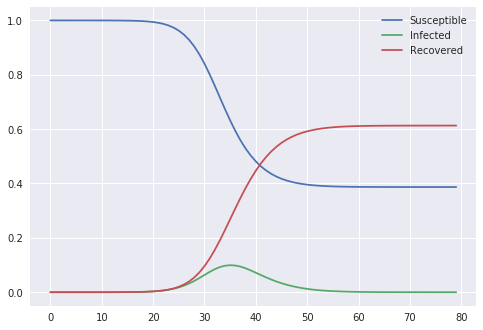

In [6]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(t, S / N, label='Susceptible')
ax.plot(t, I / N, label='Infected')
ax.plot(t, R / N, label='Recovered')
ax.legend()
plt.show()

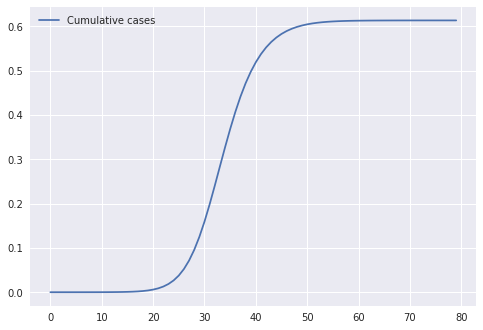

In [7]:
cases_cum = I + R
plt.plot(t, cases_cum / N, label='Cumulative cases')
plt.legend()
plt.show()

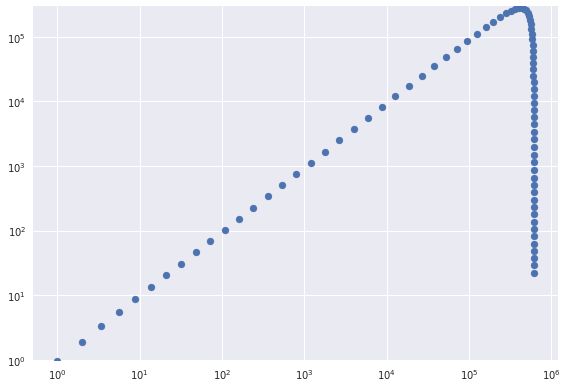

In [8]:
cases_new = calc_new_cases(cases_cum)

fig, ax = plt.subplots()
ax.scatter(cases_cum, cases_new)
ax.set_ylim(bottom=1)
ax.set_yscale('log')
ax.set_xscale('log')
plt.tight_layout()
plt.show()

## Fit reported case counts to this model
The model fits these parameters:
- $\beta_1, \beta_2$: the initial and final values of the rate of infection
- $t_1, t_2$: the start and end time of the linear $\beta$ ramp
- $\mu$: rate of recovery
- $I_0$: the number of people infected

In [9]:
# Data
#!!! TO DO Fetch this data dynamically
region = 'Italy'
if region == 'South Korea':
    N = 50e6
    y_train = np.array([1,1,2,2,3,4,4,4,4,11,12,15,15,16,19,23,24,24,25,27,28,28,28,28,28,29,30,31,31,104,204,433,602,833,977,
                  1261,1766,2337,3150,3736,4335,5186,5621,6088,6593,7041,7314,7478,7513,7755,7869,7979,8086,8162,8236,
                  8320,8413,8565,8652,8799,8961,8961,9037,9137,9241,9332,9478,9583,9661,9786,9887,9976,10062,10156,
                  10237,10284,10331,10384,10423,10450])[28:]
elif region == 'Alberta':
    N = 4.3e6
    y_train = np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,2,4,14,
                        14,19,23,29,39,56,74,97,119,146,195,226,259,301,358,419,486,542,621,661,690,754,871,968,1075,
                        1181,1250,1348,1373,1423,1451,1500,1569])[43:]
elif region == 'BC':
    N = 5.1e6
    y_train = np.array([0,0,0,0,0,0,1,1,1,1,1,1,1,1,2,4,4,4,4,4,4,4,4,5,5,5,5,5,5,6,6,6,6,7,7,7,7,7,8,8,8,12,13,21,21,27,
                        27,32,39,46,53,64,73,73,103,186,231,271,348,424,472,539,617,659,725,792,884,900,970,1013,1066,1121,
                        1174,1203,1229,1266,1291,1336,1370,1410,1445])[50:]
elif region == 'Germany':
    N = 83e6
    y_train = np.array([0,0,0,0,0,1,4,4,4,5,8,10,12,12,12,12,13,13,14,14,16,16,16,16,16,16,16,16,16,16,16,16,16,16,17,27,46,48,
                        79,130,159,196,262,482,670,799,1040,1176,1457,1908,2078,3675,4585,5795,7272,9257,12327,15320,19848,
                        22213,24873,29056,32986,37323,43938,50871,57695,62095,66885,71808,77872,84794,91159,96092,100123,
                        103374,107663,113296,118181,122171])[30:]
elif region == 'Italy':
    N = 60.36e6
    y_train = np.array([0,0,0,0,0,0,0,0,0,2,2,2,2,2,2,2,3,3,3,3,3,3,3,3,3,3,3,3,3,3,20,62,155,229,322,453,655,888,1128,
                        1694,2036,2502,3089,3858,4636,5883,7375,9172,10149,12462,12462,17660,21157,24747,27980,31506,
                        35713,41035,47021,53578,59138,63927,69176,74386,80589,86498,92472,97689,101739,105792,110574,
                        115242,119827,124632,128948,132547,135586,139422,143626,147577])[30:]
elif region == 'Quebec':
    N = 8.537e6
    y_train = np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,3,3,3,3,7,
                        7,9,17,17,21,32,50,74,94,121,139,181,219,628,1013,1339,1629,2021,2498,2840,3430,4162,4611,5518,
                        6101,6997,7944,8580,9340,10031,10912,11677,12292,12846])[50:]
elif region == 'Sweden':
    N = 10.3e6
    y_train = np.array([0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,7,7,12,14,15,21,35,94,
                        101,161,203,248,355,500,599,814,961,1022,1103,1190,1279,1439,1639,1763,1934,2046,2286,2526,
                        2840,3069,3447,3700,4028,4435,4947,5568,6131,6443,6830,7206,7693,8419,9141,9685,10151,10483])[50:]
elif region == 'US':
    N = 328.2e6
    y_train = np.array([1,1,2,2,5,5,5,5,5,7,8,8,11,11,11,11,11,11,11,11,12,12,13,13,13,13,13,13,13,13,15,15,15,51,51,
                        57,58,60,68,74,98,118,149,217,262,402,518,583,959,1281,1663,2179,2727,3499,4632,6421,7783,13747,
                        19273,25600,33276,43847,53740,65778,83836,101657,121465,140909,161831,188172,213372,243762,
                        275586,308853,337072,366667,396223,429052,461437,496535,526396])[50:]
else:
    raise RuntimeError(f'Unknown region: {region}')
t_train = np.arange(len(y_train))
print(f'cumulative cases: min: {np.min(y_train):,}, max: {np.max(y_train):,}')


cumulative cases: min: 20, max: 147,577


In [10]:
# Parameters, with initial values
t1 = 10  # 10
t2 = 30  # 30
mu = 0.35
beta1 = 2.5 * mu
beta2 = 0.8 * mu
I0 = np.min(y_train)
x0 =    np.array([t1, t2,   mu, beta1, beta2,  I0])
lower = np.array([ 0,  0, 1e-4,  1e-4,  1e-4,   1])
upper = np.array([30, 60,   10,    10,    10, 1e4])

In [11]:
def fit(x, t, y):
    """
    Function to be used for optimization
    
    Arguments:
        x     parameters to be fit
        t     independent variable
        y     observed data
    """
#     print(f'fit: x = {x}')
#     print(', '.join([f'{xitem:6.1f}' for xitem in x]))
    t1, t2, mu, beta1, beta2, I0 = x
    t0 = 0
    t3 = len(t) - 1

    
    def beta(t):
        if t <= t1:
            return beta1
        if t <= t2:
            return beta2 - (t2 - t) * (beta2 - beta1) / (t2 - t1)
        return beta2


    def fun(t, y):
        """Differential equations to be integrated
        
        Arguments
            day    
        """
        dy_dt = np.zeros_like(y)
        dy_dt[0] = -beta(t) * y[0] * y[1] / N
        dy_dt[1] = beta(t) * y[0] * y[1] / N - mu * y[1]
        dy_dt[2] = mu * y[1]
        return dy_dt

    S, I, R = solve_ivp(fun, t_span=(t0, t3), y0=(N-I0, I0, 0), t_eval=np.arange(t3 + 1)).y
#     print(f'{t0}, {t3}: {S.shape}, {I.shape}, {R.shape}')
    return I + R - y

In [12]:
res_lsq = least_squares(fit, x0, method='trf', bounds=(lower, upper), args=(t_train, y_train))

In [13]:
t1, t2, mu, beta1, beta2, I0 = res_lsq.x

In [14]:
names = ["t1", "t2", "mu", "beta1", "beta2", "I0"]
ddict = { 'parameter': [], 'initial': [], 'fit': []}
for i, name in enumerate(names):
    ddict['parameter'].append(name)
    ddict['initial'].append(x0[i])
    ddict['fit'].append(res_lsq.x[i])
df = pd.DataFrame.from_dict(ddict)
df.set_index('parameter', inplace=True)
display(df)

print(f'R initial: {beta1/mu:.1f}, R fit: {beta2/mu:.1f}')


,initial,fit
parameter,,
t1,10.000,9.856501
t2,30.000,36.930298
mu,0.350,0.473911
beta1,0.875,0.726747
beta2,0.280,0.443819
I0,20.000,46.131156


R initial: 1.5, R fit: 0.9


Final value of cumulative cases reported: 147,577
Final value of cumulative cases fit:      147,058


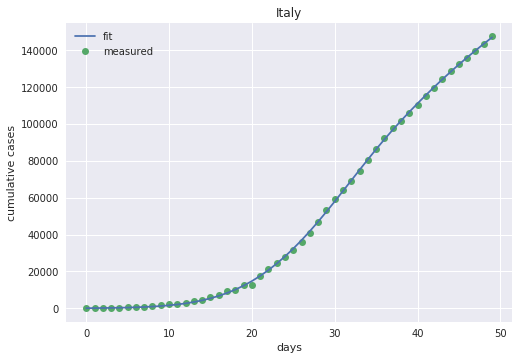

In [15]:
y_fit = fit(res_lsq.x, t_train, y_train) + y_train

print(f'Final value of cumulative cases reported: {y_train[-1]:7,.0f}')
print(f'Final value of cumulative cases fit:      {y_fit[-1]:7,.0f}')

plt.plot(t_train, y_fit, zorder=2, label='fit')
plt.plot(t_train, y_train, 'o', zorder=1, label='measured')
plt.title(region)
plt.xlabel('days')
plt.ylabel('cumulative cases')
plt.legend()
plt.show()

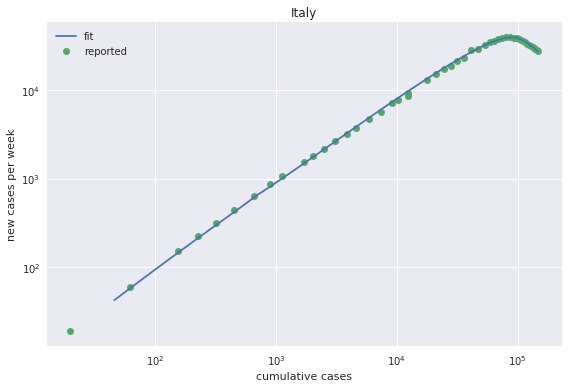

In [16]:
cases_cum_rep = y_train
cases_new_rep = calc_new_cases(cases_cum_rep)
cases_cum_fit = y_fit
cases_new_fit = calc_new_cases(cases_cum_fit)

fig, ax = plt.subplots()
ax.set_title(f'{region}')
ax.plot(cases_cum_fit, cases_new_fit, zorder=2, label='fit')
ax.plot(cases_cum_rep, cases_new_rep, 'o', zorder=1, label='reported')  # , color='#55a868'
ax.set_yscale('log')
ax.set_xscale('log')
plt.xlabel('cumulative cases')
plt.ylabel('new cases per week')
plt.tight_layout()
plt.legend()
plt.show()

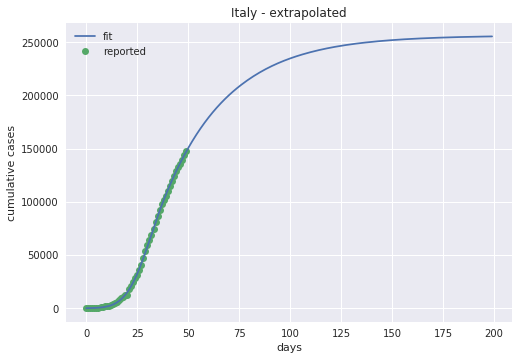

In [17]:
# Extrapolate
n_days = 200
t_train_e = np.arange(n_days)
y_train_e = np.zeros(n_days)
y_fit_e = fit(res_lsq.x, t_train_e, y_train_e) + y_train_e

plt.plot(t_train_e, y_fit_e, zorder=2, label='fit')
plt.plot(t_train, y_train, 'o', zorder=1, label='reported')
plt.title(f'{region} - extrapolated')
plt.xlabel('days')
plt.ylabel('cumulative cases')
plt.legend()
plt.show()

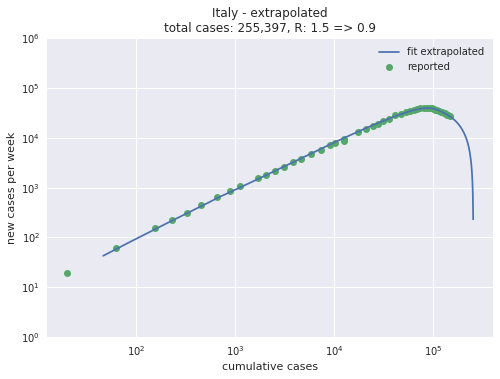

In [18]:
cases_cum_fit_e = y_fit_e
cases_new_fit_e = calc_new_cases(cases_cum_fit_e)
cases_cum = y_train
cases_new = calc_new_cases(cases_cum)

final_cases = cases_cum_fit_e[-1]
R1 = beta1 / mu
R2 = beta2 / mu
subtitle = f'total cases: {final_cases:,.0f}, R: {R1:.1f} => {R2:.1f}'
datestamp = date.today().strftime('%Y%m%d')

fig, ax = plt.subplots()
ax.set_title(f'{region} - extrapolated\n{subtitle}')
ax.plot(cases_cum_fit_e, cases_new_fit_e, zorder=2, label='fit extrapolated')
ax.plot(cases_cum, cases_new, 'o', zorder=1, label='reported')
plt.xlabel('cumulative cases')
plt.ylabel('new cases per week')
ax.set_ylim(bottom=1, top=1e6)
ax.set_yscale('log')
ax.set_xscale('log')
# fig.tight_layout()
plt.legend()
plt.savefig(f'{region.lower().replace(" ", "_")}_extrapolated_{datestamp}.png', dpi=150)
plt.show()